# Сверточные нейронные сети

Мы уже видели, что нейронные сети довольно хорошо справляются с изображениями, и даже однослойный персептрон способен распознавать рукописные цифры из набора данных MNIST с разумной точностью. Тем не менее, набор данных MNIST очень особенный, и все цифры центрированы внутри изображения, что упрощает задачу.

В реальной жизни нам необходимо распознавать объекты независимо от их точного местоположения на изображении. Когда человек смотрит на окружающий мир, он сканирует изображение в поисках каких-то конкретных **паттернов** и их комбинаций. Например, при поиске кошки мы можем сначала искать горизонтальные линии, которые образуют усы, а затем определенная комбинация усов может сказать нам, что это на самом деле изображение кошки. Важно относительное положение и наличие определенных узоров, а не их точное положение на изображении.  

Для извлечения паттернов мы будем использовать понятие **сверточные фильтры**. Именно поэтому такие нейросети называются **свёрточными**.

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

Мы продолжим рассматривать набор данных MNIST, и попробуем улучшить точность распознавания.

In [5]:
(x_train,y_train),(x_test,y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

## Сверточные фильтры

Сверточные фильтры представляют собой небольшие окна, которые проходят над каждым пикселем изображения и вычисляют средневзвешенное значение соседних пикселей.

Они определяются матрицами весовых коэффициентов, которые называются **ядрами свёртки** (*convolution kernels*). Давайте рассмотрим примеры применения двух разных сверточных фильтров к нашим рукописным цифрам MNIST.

> Функция `plot_convolution` пока вам не очень понятна - не вникайте в её внутреннее устройство!

In [10]:
def plot_convolution(data,t,title=''):
    fig, ax = plt.subplots(2,len(data)+1,figsize=(8,3))
    fig.suptitle(title,fontsize=16)
    tt = np.expand_dims(np.expand_dims(t,2),2)
    for i,im in enumerate(data):
        ax[0][i].imshow(im)
        ximg = np.expand_dims(np.expand_dims(im,2),0)
        cim = tf.nn.conv2d(ximg,tt,1,'SAME')
        ax[1][i].imshow(cim[0][:,:,0])
        ax[0][i].axis('off')
        ax[1][i].axis('off')
    ax[0,-1].imshow(t)
    ax[0,-1].axis('off')
    ax[1,-1].axis('off')
    #plt.tight_layout()
    plt.show()


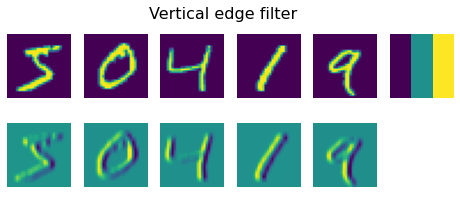

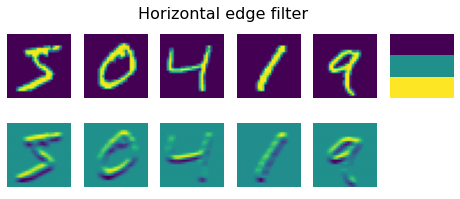

In [11]:
plot_convolution(x_train[:5],[[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]],'Vertical edge filter')
plot_convolution(x_train[:5],[[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]],'Horizontal edge filter')

Первый фильтр называется **вертикальный краевой фильтр**, и он определяется следующей матрицей:

$$
\left(
    \begin{matrix}
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
    \end{matrix}
\right)
$$

Когда этот фильтр проходит через относительно однородное пиксельное поле, все значения складываются в 0. Однако, когда он сталкивается с вертикальным краем в изображении, то получается большое значение (всплеск). Вот почему на изображениях выше вы можете увидеть, что вертикальные края как бы "подчёркиваются", в то время как горизонтальные края усреднены.

Противоположный эффект достигается применением горизонтального краевого фильтра - горизонтальные линии усиливаются, а вертикальные усредняются.

В классическом компьютерном зрении к изображению применялось несколько фильтров для генерации признаков, которые затем использовались алгоритмом машинного обучения для построения классификатора. Эти фильтры на самом деле похожи на нейронные структуры, которые доступны в системе зрения некоторых животных.

<img src="./images/lmfilters.jpg" width="400"/>

Последние фильтры - это уже известные нам разновидности сглаживания (blur, Gaussian blur и т.д.)

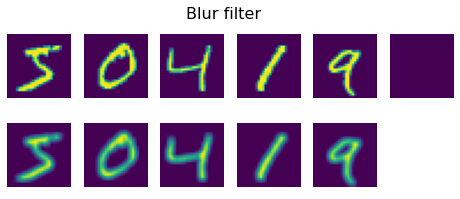

In [16]:
plot_convolution(x_train[:5],[[1.,1.,1.],[1.,1.,1.],[1.,1.,1.]],'Blur filter')

В глубоком обучении мы строим сети, которые **учатся** и подбирают матрицы поэффициентов для сверточных фильтров в зависимости от датасета. Для этого мы вводим в нейросеть **сверточные слои**.

## Свёрточные слои

Чтобы сделать веса сверточного слоя обучаемыми, нам нужно каким-то образом свести процесс применения окна сверточного фильтра к матричным операциям, которые затем могут быть подвергнуты обучению с помощью известного нам алгоритма обратного распространения. Для этого мы используем матричное преобразование, которое мы называем **im2col**.

Предположим, что у нас есть маленькое изображение $\mathbf{x}$, со следующими пикселями:

$$
\mathbf{x} = \left(
         \begin{array}{ccccc}
           a & b & c & d & e \\
           f & g & h & i & j \\
           k & l & m & n & o \\
           p & q & r & s & t \\
           u & v & w & x & y \\
         \end{array}
     \right)
$$
и мы хотим применить два свёрточных фильтра, со следующими весами:

$$
W^{(i)} = \left(\begin{array}{ccc}
            w^{(i)}_{00} & w^{(i)}_{01} & w^{(i)}_{02} \\
            w^{(i)}_{10} & w^{(i)}_{11} & w^{(i)}_{12} \\
            w^{(i)}_{20} & w^{(i)}_{21} & w^{(i)}_{22} \\
            \end{array}\right),\quad
i\in\{0,1\}
$$

При применении свертки первый пиксель результата будет получен поэлементным умножением 
$\left(\begin{array}{ccc}
  a & b & c \\
  f & g & h \\
  k & l & m \\
\end{array}\right)$ на $W^{(i)}$, второй элемент - умножением на $\left(\begin{array}{ccc}
  b & c & d \\
  g & h & i \\
  l & m & n \\
\end{array}\right)$ на $W^{(i)}$ и так далее.

Чтобы формализовать этот процесс, давайте извлечем все $3\times3$ фрагменты исходного изображения $x$ в следующую матрицу:

$$
\mathrm{im2col}(x) = \left[
        \begin{array}{cccccc}
          a & b & \ldots & g & \ldots & m \\
          b & c & \ldots & h & \ldots & n \\
          c & d & \ldots & i & \ldots & o \\
          f & g & \ldots & l & \ldots & r \\
          g & h & \ldots & m & \ldots & s \\
          h & i & \ldots & n & \ldots & t \\
          k & l & \ldots & q & \ldots & w \\
          l & m & \ldots & r & \ldots & x \\
          m & n & \ldots & s & \ldots & y \\
        \end{array}
    \right]
$$

Каждый столбец этой матрицы соответствует каждому фрагменту исходного изображения размером $3\times3$. Теперь, чтобы получить результат свертки, нам просто нужно умножить эту матрицу на матрицу весов

$$
\mathbf{W} = \left[
         \begin{array}{cccccccc}
            w^{(0)}_{00} & w^{(0)}_{01} & w^{(0)}_{02} & w^{(0)}_{10} & w^{(0)}_{11} & \ldots & w^{(0)}_{21} & w^{(0)}_{22} \\
            w^{(1)}_{00} & w^{(1)}_{01} & w^{(1)}_{02} & w^{(1)}_{10} & w^{(1)}_{11} & \ldots & w^{(1)}_{21} & w^{(1)}_{22} \\
         \end{array}
       \right]
$$
(каждая строка этой матрицы содержит веса $i$-го фильтра, сведенные в одну строку)

Таким образом, применение фильтра свертки к исходному изображению может быть заменено матричным умножением, с которым мы уже знаем, как справиться с помощью обратного распространия:
$$
C(x) = W\times\mathbf{im2col}(x)
$$

Сверточные слои определяются с помощью класса `Conv2d`. Нам нужно указать следующее:

* `filters` - количество используемых фильтров. Мы будем использовать 9 различных фильтров, что даст сети множество возможностей для распознавания различных признаков
* `kernel_size` - размер скользящего окна, т.е. ядра свёртки. Обычно используются фильтры 3х3 или 5х5.

Простейшая свёрточная сеть (CNN) будет содержать один сверточный слой. Учитывая входной размер 28x28, после применения девяти фильтров 5x5 мы получим тензор 24x24x9. Пространственное измерение меньше, потому что есть только 24 позиции, где скользящее окно размером 5x5 может уместиться внутри изображения 28x28.

После свертки мы преобразуем тензор 24x24x9 в один вектор размером 5184, а затем добавляем линейный слой, чтобы получить на выходе сети 10 классов. Мы также используем функцию активации `relu` между слоями.

In [21]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=9, kernel_size=(5,5), input_shape=(28,28,1),activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(10)
])

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['acc'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 9)         234       
_________________________________________________________________
flatten_4 (Flatten)          (None, 5184)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                51850     
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
_________________________________________________________________


Вы можете видеть, что эта сеть содержит около 50 тыс. обучаемых параметров, по сравнению с примерно 100 тыс. в многоуровневой полносвязной сети. Это позволяет нам достигать хороших результатов даже на небольших наборах данных, потому что сверточные сети гораздо лучше обобщаются.

> **Примечание**: В большинстве случаев мы будем применять сверточные слои к цветным изображениям. Таким образом, слой `Conv2D` ожидает, что входные данные будут иметь форму $W\times H\times C$, где $W$ и $H$ - ширина и высота изображения, а $C$ - количество цветовых каналов. Для изображений в градациях серого нам нужна такая же конфигурация с $C = 1$.

Нам нужно добавить к исходному датасету ещё одно измерение цветности с помощью `expand_dims`:

In [5]:
x_train_c = np.expand_dims(x_train,3)
x_test_c = np.expand_dims(x_test,3)
hist = model.fit(x_train_c,y_train,validation_data=(x_test_c,y_test),epochs=5)

Epoch 1/5
1875/1875 [==============================] - 15s 7ms/step - loss: 0.2099 - acc: 0.9410 - val_loss: 0.0879 - val_acc: 0.9735
Epoch 2/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0858 - acc: 0.9753 - val_loss: 0.0682 - val_acc: 0.9791
Epoch 3/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0665 - acc: 0.9808 - val_loss: 0.0553 - val_acc: 0.9829
Epoch 4/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0582 - acc: 0.9835 - val_loss: 0.0513 - val_acc: 0.9835
Epoch 5/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0527 - acc: 0.9847 - val_loss: 0.0503 - val_acc: 0.9833


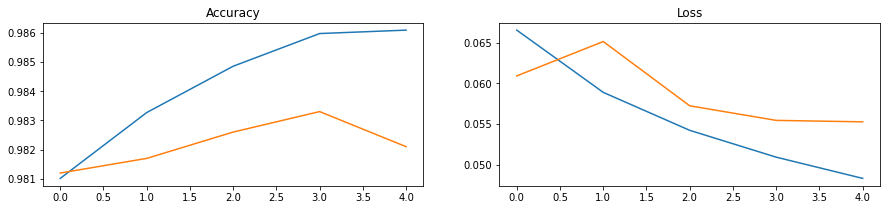

In [ ]:
def plot_results(hist):
    fig,ax = plt.subplots(1,2,figsize=(15,3))
    ax[0].set_title('Accuracy')
    ax[1].set_title('Loss')
    for x in ['acc','val_acc']:
        ax[0].plot(hist.history[x])
    for x in ['loss','val_loss']:
        ax[1].plot(hist.history[x])
    plt.show()

plot_results(hist)

Как видите, мы способны добиться более высокой точности, чем в случае с полносвязными сетями, причем гораздо быстрее (по количеству эпох). Однако само обучение требует больше ресурсов и может быть медленнее на компьютерах без графического процессора.

## Визуализация сверточных слоев

Мы также можем визуализировать веса наших обученных сверточных слоев, чтобы попытаться лучше понять, что происходит:

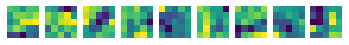

In [ ]:
fig,ax = plt.subplots(1,9)
l = model.layers[0].weights[0]
for i in range(9):
    ax[i].imshow(l[...,0,i])
    ax[i].axis('off')

Вы можете видеть, что некоторые из этих фильтров выглядят так, как будто они могут распознавать наклонные штрихи, в то время как другие выглядят довольно случайно. 

> **Задача**: Обучите ту же сеть с фильтрами 3x3 и визуализируйте их. Видите ли вы более знакомые шаблоны?

## Многослойные CNN и субдискретизация

Первые сверточные слои ищут примитивные паттерны, такие как горизонтальные или вертикальные линии, которые укладываются в размеры фильтра (3x3 или 5x5). Мы можем применить дополнительные сверточные слои поверх них, чтобы искать шаблоны более высокого уровня, такие, как примитивные фигуры. Затем  сверточные слои ещё более высокого уровня могут объединять эти формы в некоторые части картины, вплоть до конечного объекта, который мы пытаемся классифицировать. 

При этом мы также можем применить один трюк: уменьшить пространственный размер изображения. После того, как мы обнаружили, что в скользящем окне 3x3 есть горизонтальный штрих, не так важно, на каком именно пикселе это произошло. Таким образом, мы можем «уменьшить» размер изображения, сохранив всю информацию. Это делается с помощью одного из **слоев субдискретизации**, или **пулинга**:

 * **Average Pooling** принимает скользящее окно (например, 2x2 пикселя) и вычисляет среднее значение значений в окне. В некотором смысле это аналог размывающего фильтра blur
 
 * **Max Pooling** заменяет окно максимальным значением. Идея заключается в том, чтобы обнаружить сам факт наличия определенного шаблона в скользящем окне.

Таким образом, типичная CNN состоит их нескольких сверточных слоев, перемежающихся слоями субдисретизации, чтобы уменьшать пространственные размеры изображения. При этом количество фильтров, наоборот, увеличивается, поскольку что по мере того, как шаблоны становятся более продвинутыми - появляется все больше возможных интересных комбинаций, которые нам нужно искать.

![Изображение, показывающее несколько сверточных слоев с пулинговыми слоями](./images/cnn-pyramid.png)

Из-за уменьшения пространственных размеров и увеличения количества фильтров эта архитектура также называется **пирамидальной архитектурой**. 

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=10, kernel_size=(5,5), input_shape=(28,28,1),activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(filters=20, kernel_size=(5,5), activation='relu'),
    keras.layers.MaxPooling2D(),    
    keras.layers.Flatten(),
    keras.layers.Dense(10)
])

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 10)        260       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 20)          5020      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 20)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3210      
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
____________________________________________________

Обратите внимание, что количество обучаемых параметров (~8500) значительно меньше, чем в предыдущих случаях. Это происходит потому, что сверточные слои в целом имеют мало параметров, и основную роль играет размерность изображения перед конечным полносвязным слоем. Субдискретизация позволяет сильно снизить это количество. Небольшое количество параметров положительно влияет на наши модели, поскольку помогает предотвратить переобучение даже на меньших размерах наборов данных.

In [ ]:
hist = model.fit(x_train_c,y_train,validation_data=(x_test_c,y_test),epochs=5)

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0723 - acc: 0.9780 - val_loss: 0.0423 - val_acc: 0.9861
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0523 - acc: 0.9842 - val_loss: 0.0425 - val_acc: 0.9866
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0448 - acc: 0.9868 - val_loss: 0.0403 - val_acc: 0.9865
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0383 - acc: 0.9886 - val_loss: 0.0323 - val_acc: 0.9888
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0338 - acc: 0.9895 - val_loss: 0.0331 - val_acc: 0.9896


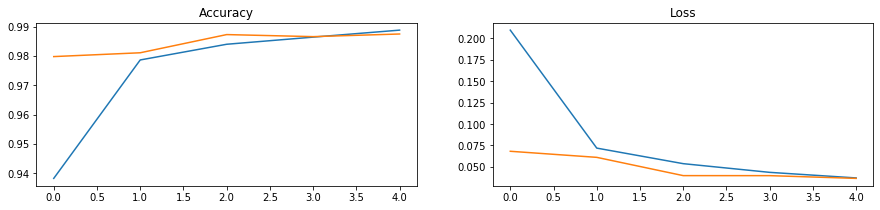

In [ ]:
plot_results(hist)

Обратите внимание, что мы достигаем более высокой точности, и гораздо быстрее с точки зрения количества эпох - только с 1 или 2 эпохами. Это означает, что сложная сетевая архитектура требует гораздо меньше данных для обучения, поскольку требуется обучить меньшее количество параметров. Тем не менее, обучение также занимает больше времени и часто требует графического процессора.

## Датасет CIFAR-10

Задача распознавания рукописных цифр может показаться игрушечной, но теперь мы готовы сделать что-то более серьезное. Давайте рассмотрим более продвинутый датасет изображений различных объектов, называемый [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). Он содержит 60k изображений 32x32, разделенных на 10 классов. 

In [22]:
(x_train,y_train),(x_test,y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

170508288/170498071 [==============================] - 783s 5us/step


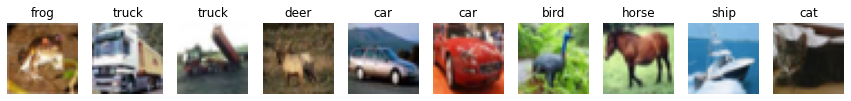

In [23]:
def display_dataset(dataset, labels=None, n=10, classes=None):
    fig,ax = plt.subplots(1,n,figsize=(15,3))
    for i in range(n):
        ax[i].imshow(dataset[i])
        ax[i].axis('off')
        if classes is not None and labels is not None:
            ax[i].set_title(classes[labels[i][0]])

display_dataset(x_train,y_train,classes=classes)

Хорошо известная архитектура для CIFAR-10 называется [LeNet](https://en.wikipedia.org/wiki/LeNet) - она  была предложена [Yann LeCun](https://ru.wikipedia.org/wiki/Лекун,_Ян). Он следует тем же принципам, которые мы изложили выше, основным отличием является 3 входных цветовых канала вместо 1. 

In [24]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters = 6, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (32,32,3)),
    keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
    keras.layers.Conv2D(filters = 16, kernel_size = 5, strides = 1, activation = 'relu'),
    keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
    keras.layers.Flatten(),
    keras.layers.Dense(120, activation = 'relu'),
    keras.layers.Dense(84, activation = 'relu'),
    keras.layers.Dense(10, activation = 'softmax')])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_8 (Dense)              (None, 84)               

Обучение этой сети займет чуть больше времени, и по возможности стоит использовать для этого GPU.

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
hist = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10)

Epoch 1/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6205 - acc: 0.4033 - val_loss: 1.4287 - val_acc: 0.4743
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3435 - acc: 0.5154 - val_loss: 1.2804 - val_acc: 0.5412
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.2225 - acc: 0.5645 - val_loss: 1.2164 - val_acc: 0.5600
Epoch 4/10
1563/1563 [==============================] - 5s 4ms/step - loss: 1.1360 - acc: 0.5957 - val_loss: 1.1918 - val_acc: 0.5768
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.0776 - acc: 0.6178 - val_loss: 1.1451 - val_acc: 0.5906
Epoch 6/10
1563/1563 [==============================] - 5s 4ms/step - loss: 1.0228 - acc: 0.6370 - val_loss: 1.1178 - val_acc: 0.6098
Epoch 7/10
1563/1563 [==============================] - 5s 4ms/step - loss: 0.9769 - acc: 0.6544 - val_loss: 1.0793 - val_acc: 0.6202
Epoch 8/10
1563/1563 [==============================] - 5s 3ms

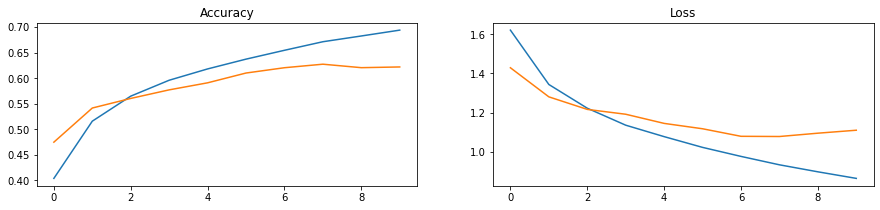

In [ ]:
plot_results(hist)

Точность, которую мы смогли достичь за несколько эпох обучения, не кажется слишком большой. Тем не менее, помните, что слепое угадывание даст нам только 10% точности, и что наша проблема на самом деле значительно сложнее, чем классификация цифр MNIST. Получение точности выше 50% за такое короткое время обучения кажется хорошим достижением.

## Выводы

Мы изучили основную концепцию нейронных сетей компьютерного зрения - сверточные сети. Реальные архитектуры, которые обеспечивают классификацию изображений, обнаружение объектов и даже сети генерации изображений, основаны на CNN, просто с большим количеством слоев и некоторыми дополнительными методами обучения.